In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
from scipy import signal as scisig

In [2]:
sess = tf.InteractiveSession()

In [3]:
sample_rate = 16000 # Hz
X = tf.placeholder(tf.float32, shape=[None], name='signal')

nunits = 16
filter_time = 0.05 # seconds
lfilter = int(filter_time*sample_rate) # number of samples in a filter
# initialize filters...they get set to gammachirps later, though
filters = tf.Variable(tf.random_normal([nunits, lfilter]), name='filters')

Xnow = tf.placeholder(tf.float32, shape=[lfilter], name='signal_segment')
filX = tf.squeeze(tf.matmul(filters, tf.expand_dims(Xnow,dim=1)))
candidate = tf.cast(tf.argmax(tf.abs(filX), axis=0), tf.int32)
cand_contrib = tf.scalar_mul(filX[candidate],filters[candidate])

# define op for learning (which I haven't done yet), not sure the reconstruction is right
final_coeffs = tf.placeholder(tf.float32, shape=[nunits, None], name='final_coefficients')
Xhat = tf.nn.convolution(tf.expand_dims(final_coeffs, dim=0), 
                         tf.transpose(tf.expand_dims(filters, dim=2),[1,0,2]),
                         padding="VALID", data_format="NCW") # needs attention
loss = tf.reduce_mean(tf.square(X - tf.squeeze(Xhat)), name='loss')
learn_rate = 0.01
learner = tf.train.GradientDescentOptimizer(learn_rate)
learn_step = tf.Variable(0,name='learn_step', trainable=False)
learn_op = learner.minimize(loss, global_step=learn_step, var_list=[filters])
normalize = filters.assign(tf.nn.l2_normalize(filters, dim=1, epsilon=1e-30))

In [29]:
def infer(signal, lam):
    lsig = signal.shape[0]
    resid = np.concatenate([signal, np.zeros(lfilter-1)], axis=0)
    recon = np.zeros_like(resid)
    lspikes = resid.shape[0]
    spikes = np.zeros([nunits, lspikes])
    for tt in range(lfilter, lspikes):
        filout, cand, contrib = sess.run((filX, candidate, cand_contrib), feed_dict = {Xnow : resid[tt-lfilter:tt]})
        sp = filout[cand]
        if np.abs(sp) > lam:
            resid[tt-lfilter:tt] -= contrib
            recon[tt-lfilter:tt] += contrib
            spikes[cand, tt] = sp
    return spikes, recon
    #return np.concatenate([np.zeros([nunits, lfilter-1]),spikes], axis=1)
    
def np_infer(signal, lam):
    lsig = signal.shape[0]
    resid = np.concatenate([signal, np.zeros(lfilter-1)], axis=0)
    recon = np.zeros_like(resid)
    lspikes = resid.shape[0]
    spikes = np.zeros([nunits, lspikes])
    Phi = filters.eval()
    for tt in range(lfilter, lspikes):
        filX = Phi @ resid[tt-lfilter:tt]
        cand = np.argmax(np.abs(filX))
        sp = filX[cand]
        if np.abs(sp) > lam:
            contrib = filX[cand]*Phi[cand]
            resid[tt-lfilter:tt] -= contrib
            recon[tt-lfilter:tt] += contrib
            spikes[cand, tt] = sp
    return spikes, recon

In [5]:
# dynamic compressive gammachirp
def dcGC(t,f):
    """Dynamic compressive gammachirp filter as defined by Irino,
    with parameters from Park as used in Charles, Kressner, & Rozell.
    The log term is regularized to log(t + 0.00001).
    t : time in seconds, greater than 0
    f : characteristic frequency in Hz
    One but not both arguments may be numpy arrays.
    """
    ERB = 0.1039*f + 24.7
    return t**3 * np.exp(-2*np.pi*1.14*ERB*t) * np.cos(2*np.pi*f*t + 0.979*np.log(t+0.000001))

gammachirps = np.zeros([nunits, lfilter])
freqs = np.logspace(np.log10(100), np.log10(6000), nunits)
times = np.linspace(0,filter_time,lfilter)
for ii in range(nunits):
    gammachirps[ii] = dcGC(times, freqs[ii])

In [6]:
sess.run(tf.global_variables_initializer())
sess.run(filters.assign(tf.constant(gammachirps.reshape([nunits,lfilter]), dtype=tf.float32)))
sess.run(normalize)

array([[  0.00000000e+00,  -2.86449534e-07,  -1.70490580e-06, ...,
         -5.25421638e-04,  -5.16042637e-04,  -5.05972013e-04],
       [  0.00000000e+00,  -3.90322498e-07,  -2.26972179e-06, ...,
          1.93682543e-04,   1.84805249e-04,   1.75619818e-04],
       [  0.00000000e+00,  -5.64142965e-07,  -3.17705872e-06, ...,
          4.43322679e-05,   3.98073025e-05,   3.52227180e-05],
       ..., 
       [  0.00000000e+00,  -2.56134954e-04,   7.07526319e-03, ...,
          0.00000000e+00,   0.00000000e+00,  -0.00000000e+00],
       [  0.00000000e+00,   4.75309062e-04,   7.54523044e-03, ...,
         -0.00000000e+00,  -0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   4.01952025e-03,  -2.10411232e-02, ...,
          0.00000000e+00,   0.00000000e+00,  -0.00000000e+00]], dtype=float32)

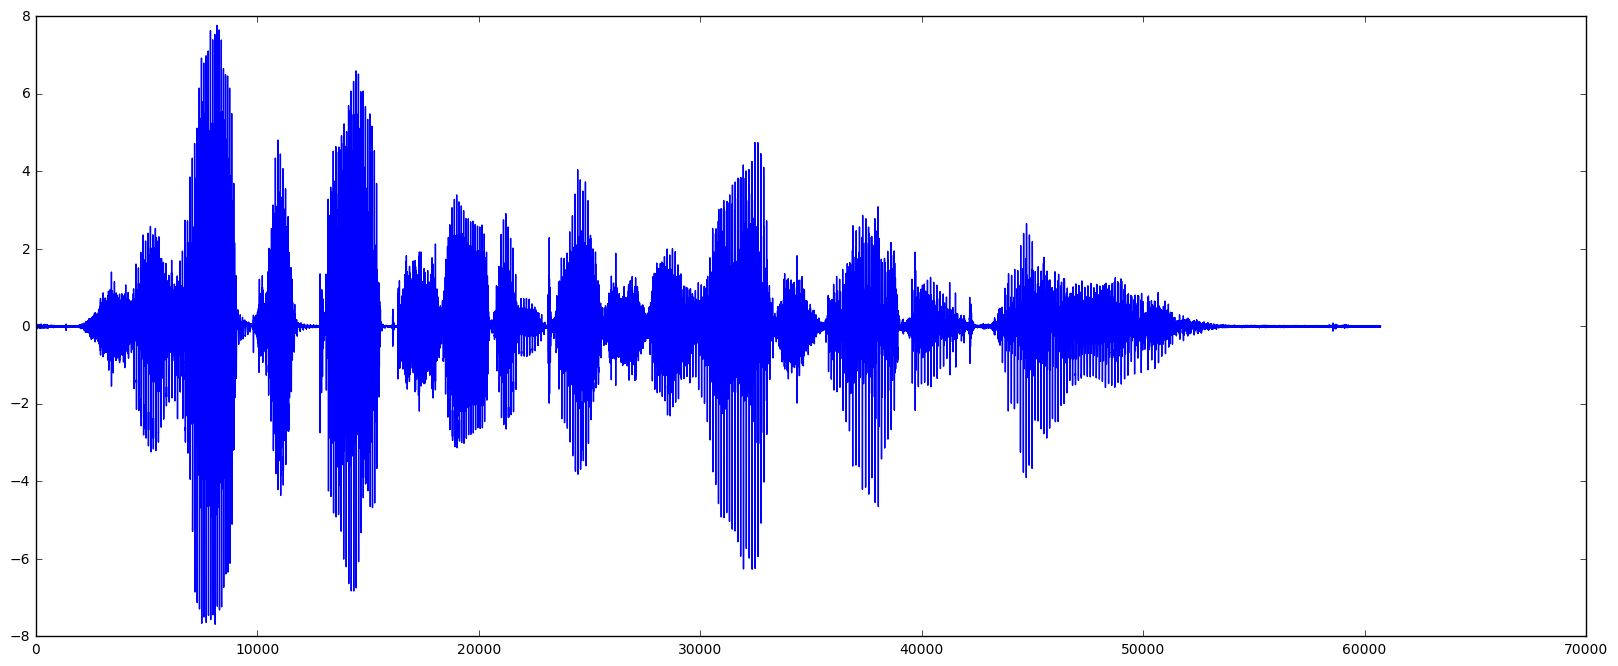

In [7]:
folder = '../Data/TIMIT/'
files = os.listdir(folder)
file = None
for ff in files:
    if ff.endswith('.wav'):
        file = os.path.join(folder,ff)
        break
rate, signal = wavfile.read(file)
# bandpass
signal = signal/signal.std()

# adapted from scipy cookbook
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = scisig.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = scisig.lfilter(b, a, data)
    return y

lowcut = 100
highcut = 6000
signal = butter_bandpass_filter(signal, lowcut, highcut, sample_rate, order=5)

plt.figure(figsize=(20,8))
plt.plot(signal)

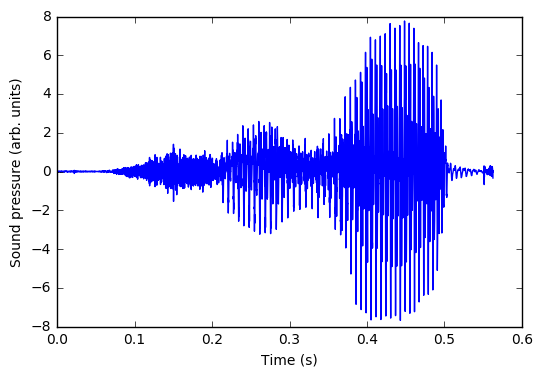

In [8]:
start = 1000
end = 10000
times = np.linspace(0, (end - start)/sample_rate,end-start)
plt.plot(times, signal[start:end])
plt.xlabel('Time (s)')
plt.ylabel('Sound pressure (arb. units)')

In [32]:
spikes, recon = infer(signal[start:end], 0.1)

In [33]:
np_spikes, np_recon = np_infer(signal[start:end], 0.1)

In [10]:
def plotSpikeGram( spikes, markerSize = .0001 ):
    """adapted from https://github.com/craffel/spikegram-coding/blob/master/plotSpikeGram.py"""
    nkernels = spikes.shape[0]
    indices = np.transpose(np.nonzero(spikes))
    print(indices.shape)
    scalesKernelsAndOffsets = [(spikes[idx[0],idx[1]], idx[0], idx[1]) for idx in indices]
    
    for scale, kernel, offset in scalesKernelsAndOffsets:
        # Put a dot at each spike location.  Kernels on y axis.  Dot size corresponds to scale
        plt.plot( offset/sample_rate, nkernels-kernel, 'k.', markersize=markerSize*np.abs( scale ) )
    plt.title( "Spikegram" )
    plt.xlabel( "Time (s)" )
    plt.ylabel( "Kernel" )
    plt.axis( [0.0, spikes.shape[1]/sample_rate, 0.0, nkernels] )
    plt.show()

(6859, 2)


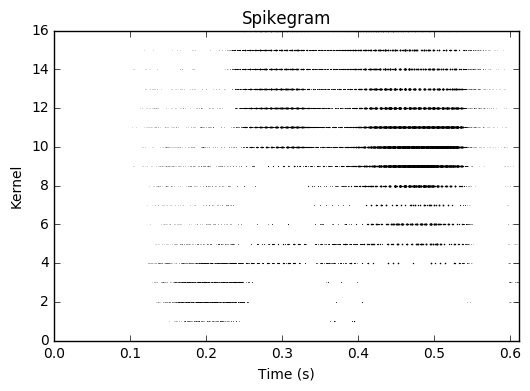

In [11]:
plotSpikeGram(spikes, 1)

(6859, 2)


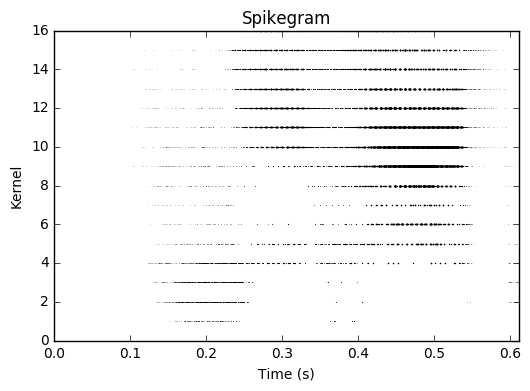

In [34]:
plotSpikeGram(np_spikes,1)

In [12]:
feed_dict = {X : signal[start:end], final_coeffs : spikes}
#sess.run(learn_op, feed_dict = feed_dict)

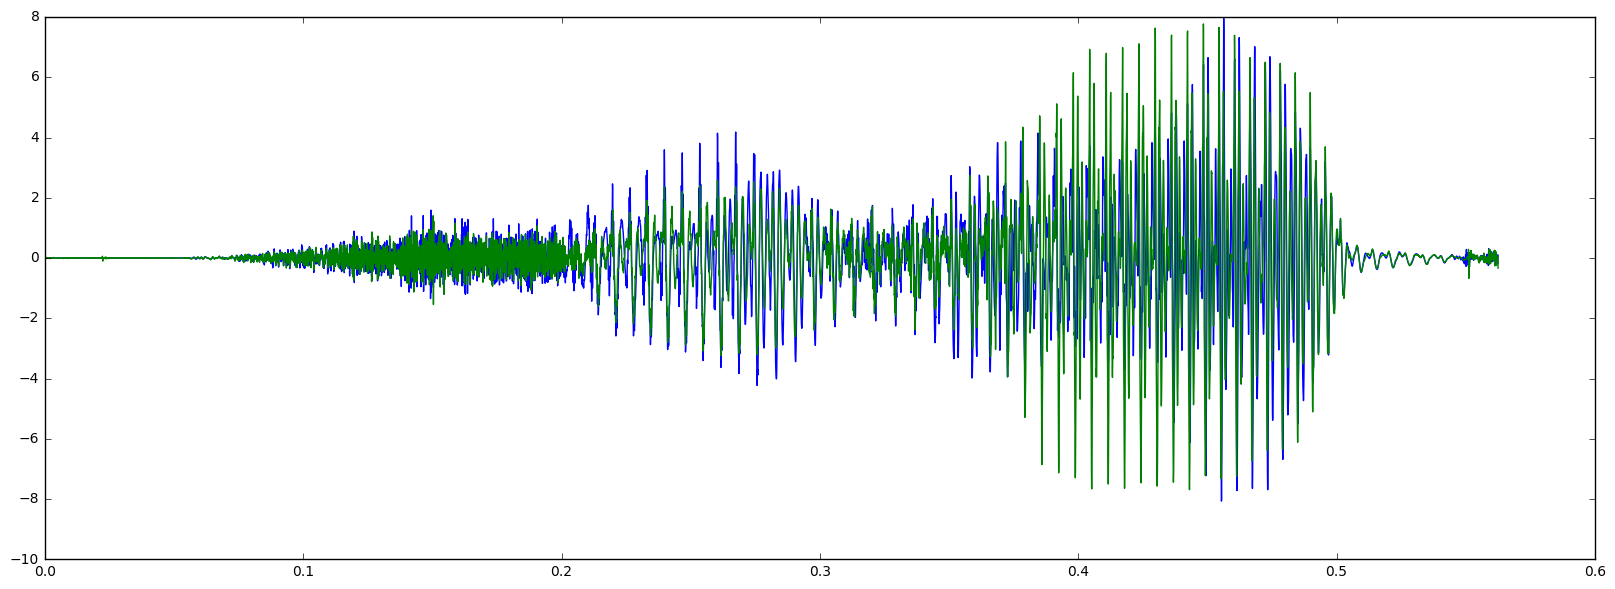

In [24]:
plt.figure(figsize=(20,7))
plt.plot(times, recon[:end-start], 'b', times, signal[start:end], 'g')

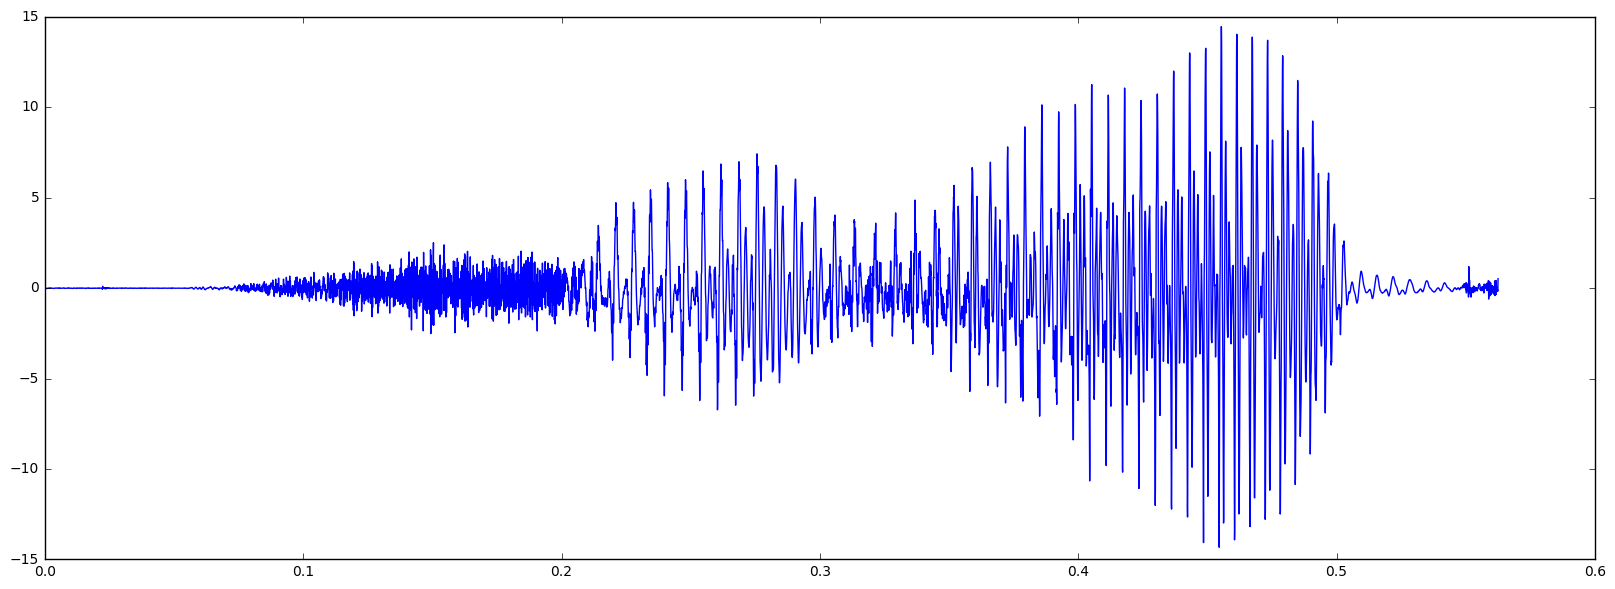

In [21]:
plt.figure(figsize=(20,7))
plt.plot(times, recon[:end-start]-signal[start:end])

In [14]:
recon2 = sess.run([Xhat], feed_dict=feed_dict)[0][0,0]

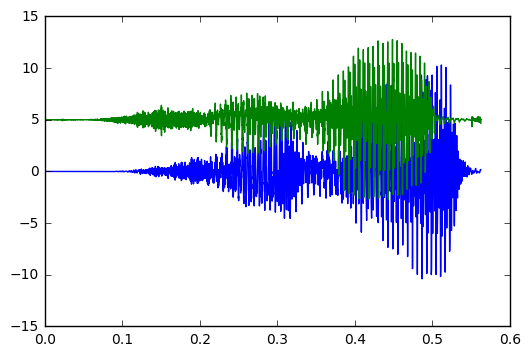

In [15]:
plt.plot(times, recon2, 'b', times, signal[start:end]+5, 'g')

In [16]:
def snr(signal, recon):
    """Returns signal-noise ratio in dB."""
    ratio = np.var(signal)/np.var(signal-recon)
    return 10*np.log10(ratio)

In [25]:
snr(signal[start:end], recon[:end-start])

1.4950216278229651

In [18]:
np.linalg.norm(filters.eval(),axis=1)

array([ 0.99999994,  0.99999994,  1.        ,  1.        ,  1.        ,
        1.        ,  0.99999994,  1.        ,  1.        ,  1.        ,
        0.99999994,  1.        ,  1.        ,  0.99999994,  1.        ,  1.        ], dtype=float32)

In [19]:
altrecon = np.sum([np.convolve(spikes[ii],filters.eval()[ii,::-1],'valid') for ii in range(nunits)],axis=0)

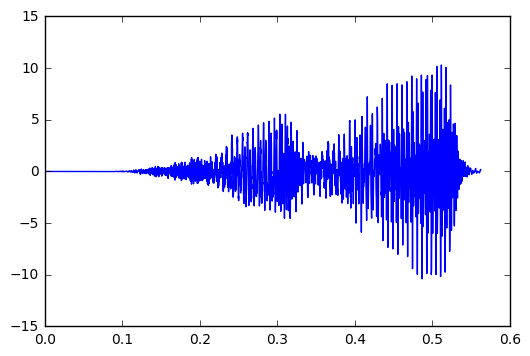

In [20]:
plt.plot(times, altrecon)

In [35]:
np_altrecon = np.sum([np.convolve(np_spikes[ii],filters.eval()[ii,::-1],'valid') for ii in range(nunits)],axis=0)

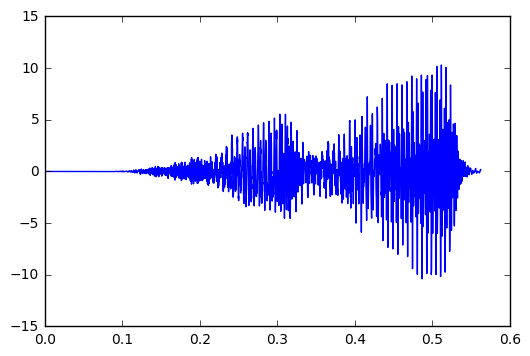

In [36]:
plt.plot(times, np_altrecon)

In [37]:
np.allclose(alt_recon, np_altrecon)

NameError: name 'alt_recon' is not defined